<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=160px> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Understanding COVID-19 with Pandas and NetworkX</h1>
<h1>Network Models</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 

import networkx as nx

import tqdm as tq
from tqdm import tqdm

import watermark

from NetworkEpiModel import *

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 21.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: 792f78317ecef2e33990957fccb9f5b18773bf8c

watermark : 2.1.0
pandas    : 1.1.3
json      : 2.0.9
scipy     : 1.6.1
matplotlib: 3.3.2
numpy     : 1.19.2
tqdm      : 4.62.0
networkx  : 2.5



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# A simple Model

Let us start with a network where eveyrone is connected to everybody else

In [4]:
N = 300
G_full = nx.erdos_renyi_graph(N, p=1.)

And an SI model

In [5]:
SI_full = NetworkEpiModel(G_full)
SI_full.add_interaction('S', 'I', 'I', 0.02)
SI_full

Epidemic Model with 2 compartments and 1 transitions:

S + I = I 0.020000

In [6]:
print("kavg=", SI_full.kavg_)
print(SI_full.transitions.edges(data=True))

kavg= 299.0
[('S', 'I', {'agent': 'I', 'rate': 0.02})]


We perform 10 runs

In [7]:
def simulate_runs(model, Nruns):
    values = []
    Nruns = 10

    for i in tqdm(range(Nruns), total=Nruns):
        model.simulate(100, seeds={30: 'I', 60:'I', 90:'I'})
        values.append(model.I)

    values =  pd.DataFrame(values).T
    values.columns = np.arange(values.shape[1])
    
    return values

In [8]:
Nruns = 10
values_full = simulate_runs(SI_full, Nruns)

100%|██████████| 10/10 [01:02<00:00,  6.29s/it]


And plot them. Each run has it's own stochastic path, despite the strong connectivity constraint

Text(0, 0.5, 'Population')

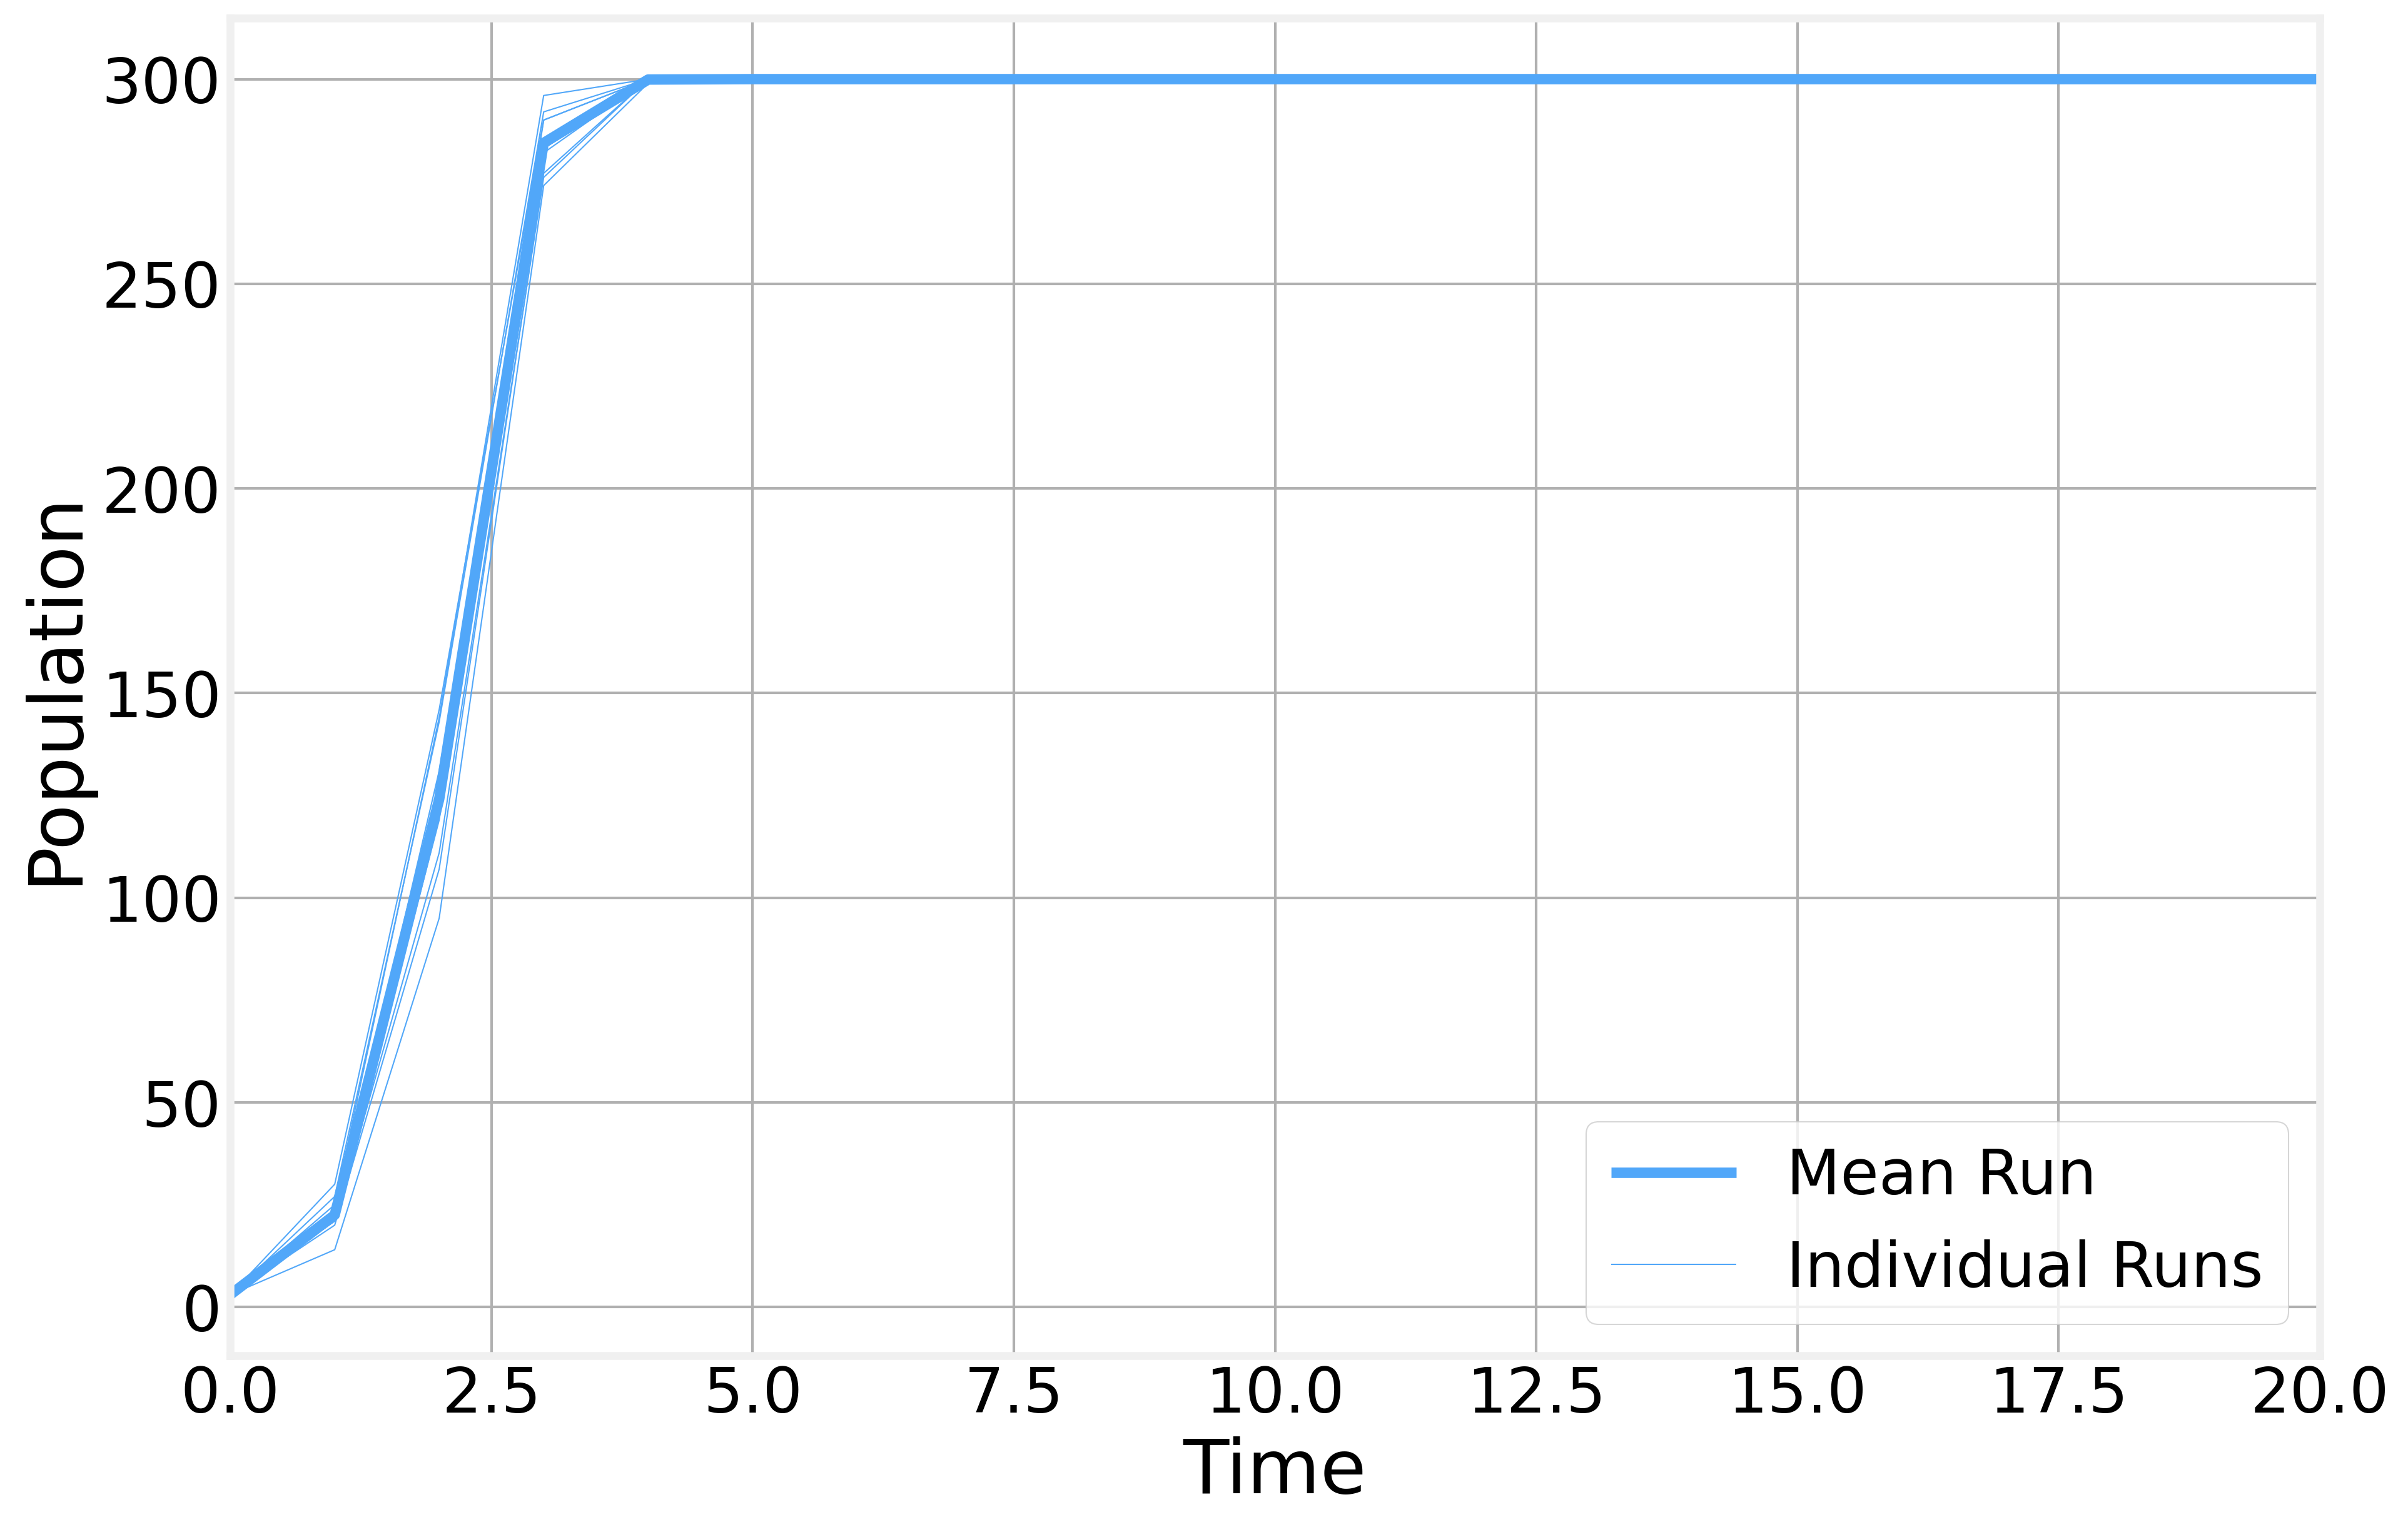

In [9]:
fig, ax = plt.subplots(1)

values_full.mean(axis=1).plot(ax=ax, color=colors[0])
values_full.plot(ax=ax, color=colors[0], lw=.5)
ax.get_legend().remove()
ax.set_xlim(0, 20)
ax.legend(['Mean Run', 'Individual Runs'])
ax.set_xlabel('Time')
ax.set_ylabel('Population')

In [10]:
G_small = nx.erdos_renyi_graph(N, p=0.0198)

In [11]:
SI_small = NetworkEpiModel(G_small)
SI_small.add_interaction('S', 'I', 'I', 0.02)
SI_small

Epidemic Model with 2 compartments and 1 transitions:

S + I = I 0.020000

In [12]:
SI_small.kavg_

5.993333333333333

In [13]:
values_small = simulate_runs(SI_small, Nruns)

100%|██████████| 10/10 [00:01<00:00,  8.43it/s]


Text(0, 0.5, 'Population')

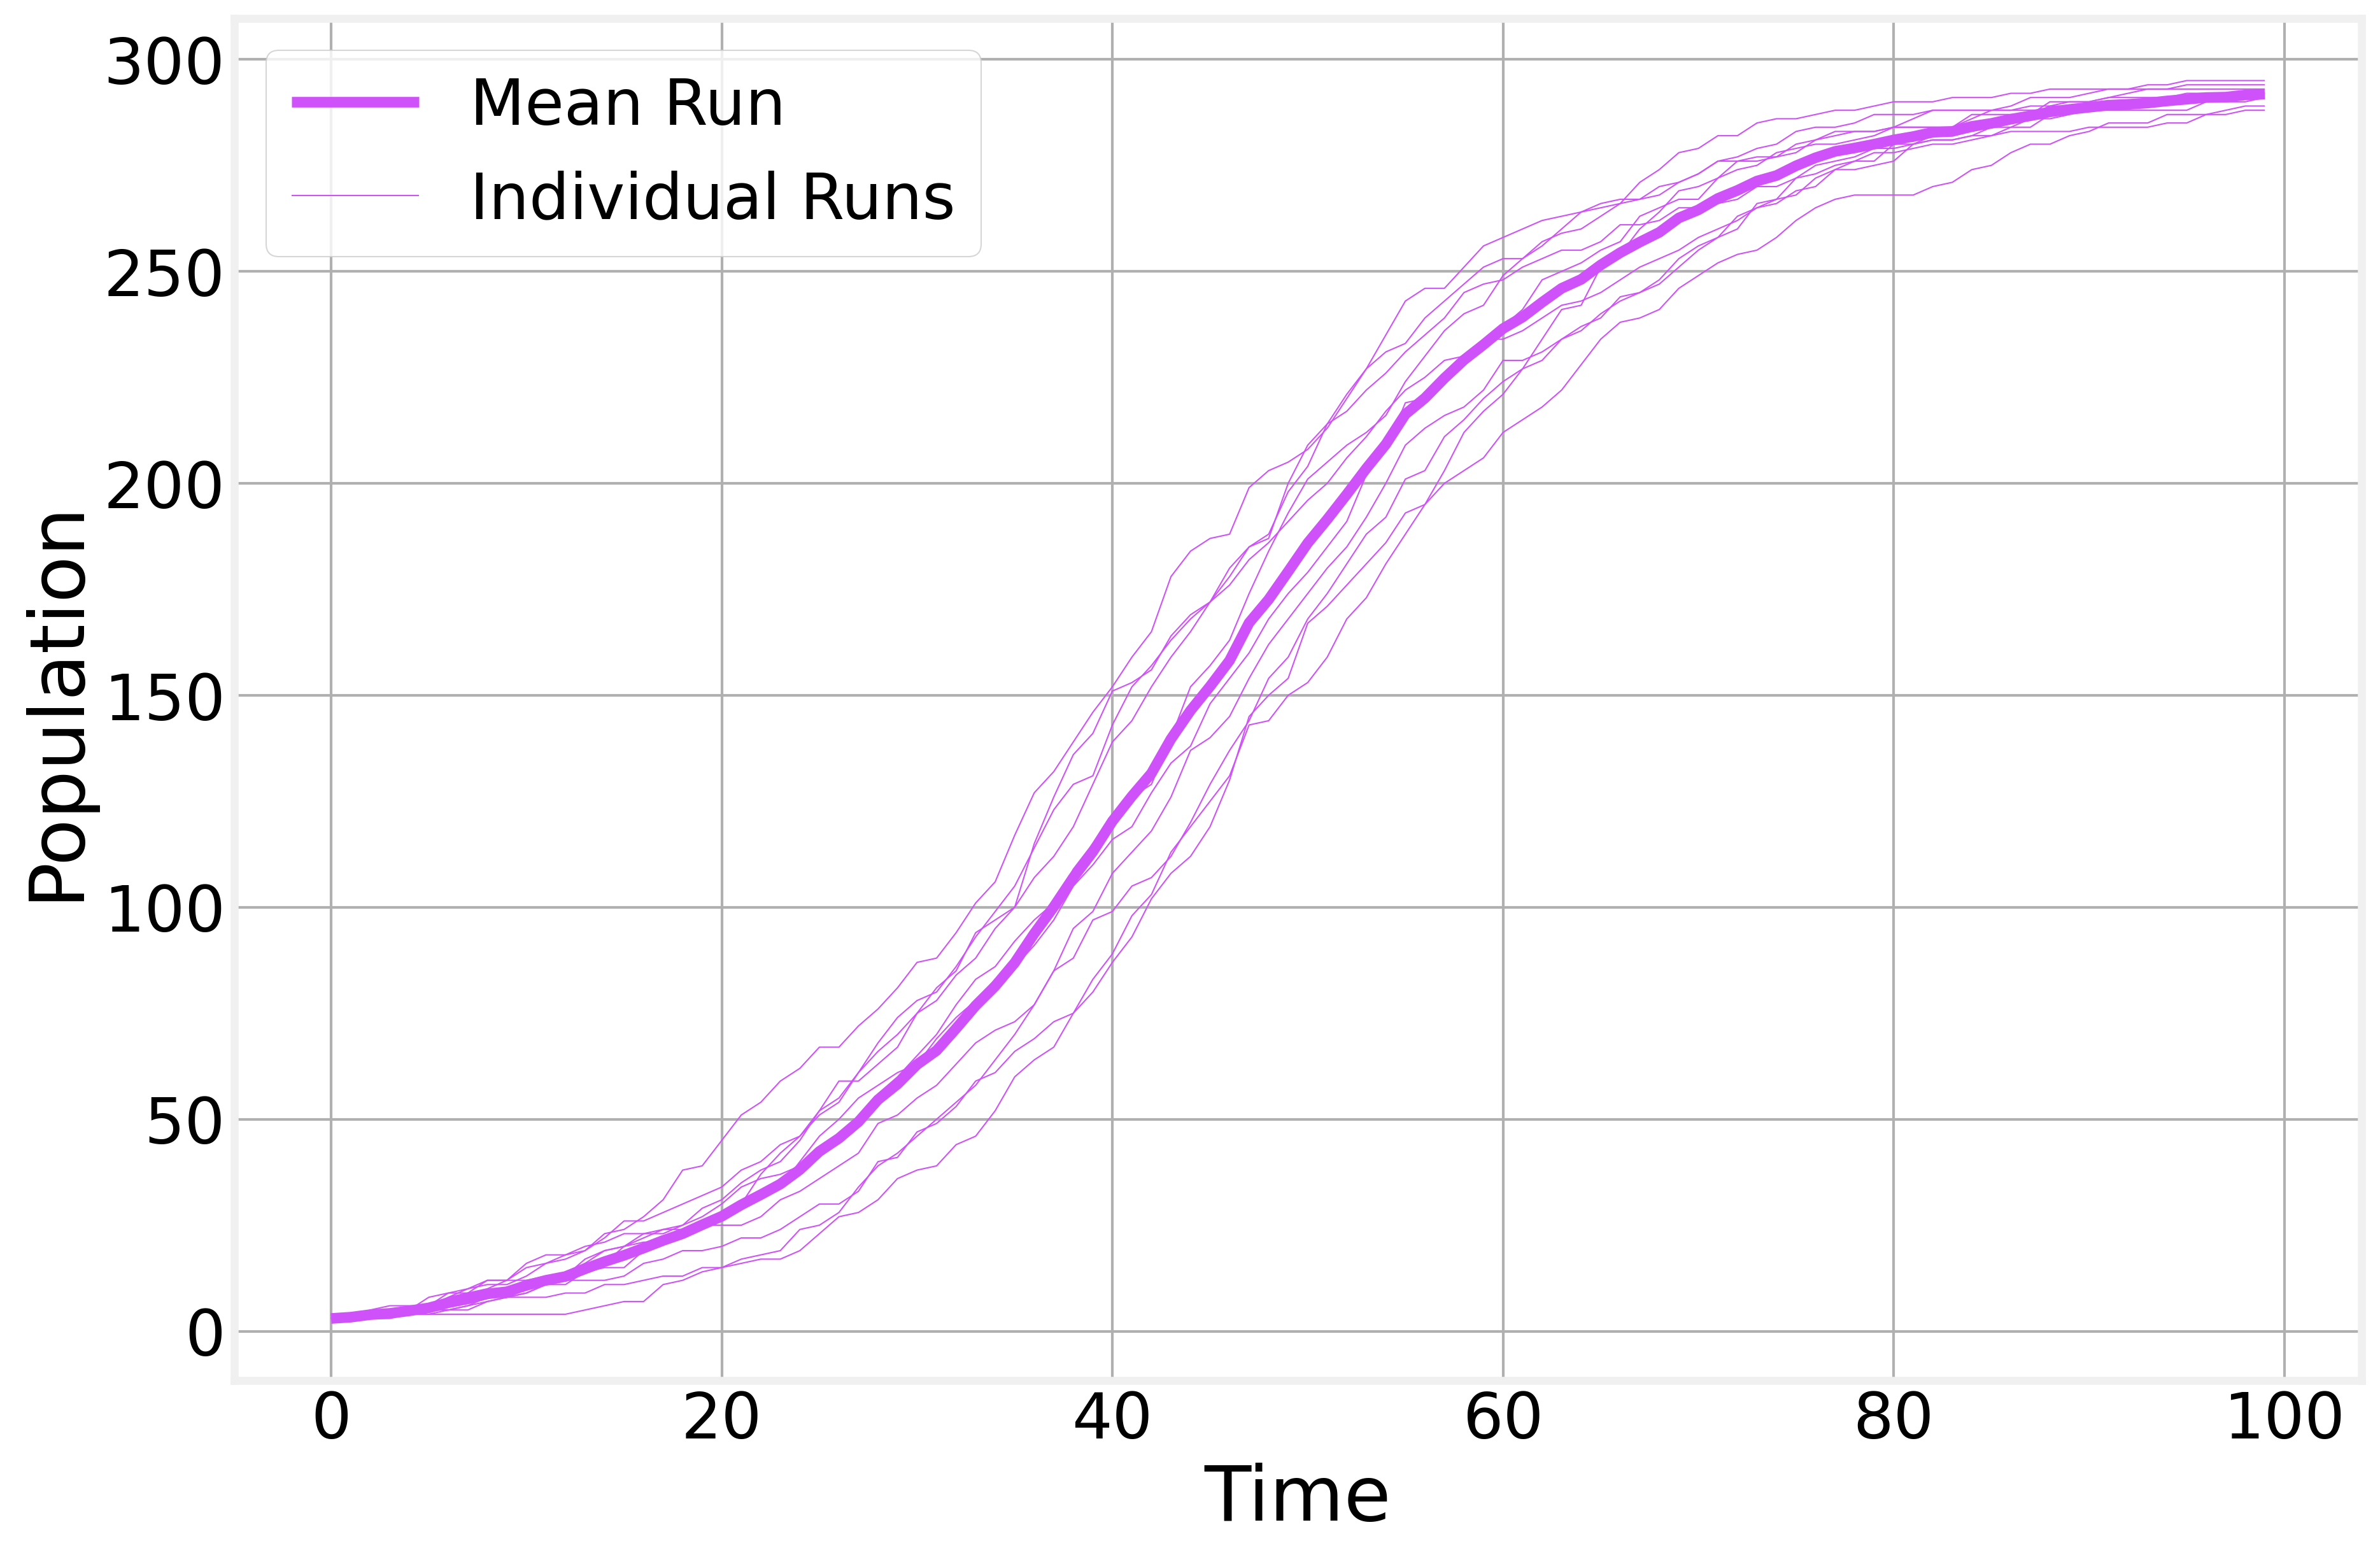

In [14]:
fig, ax = plt.subplots(1)

values_small.mean(axis=1).plot(ax=ax, color=colors[1])
values_small.plot(ax=ax, color=colors[1], lw=.5)
ax.get_legend().remove()
ax.legend(['Mean Run', 'Individual Runs'])
ax.set_xlabel('Time')
ax.set_ylabel('Population')

We can compare the two scenarios above by plotting the mean number of infected node as a function of time. Not surprisingly, the network with the smallest average connectivity is slower

Text(0, 0.5, 'Population')

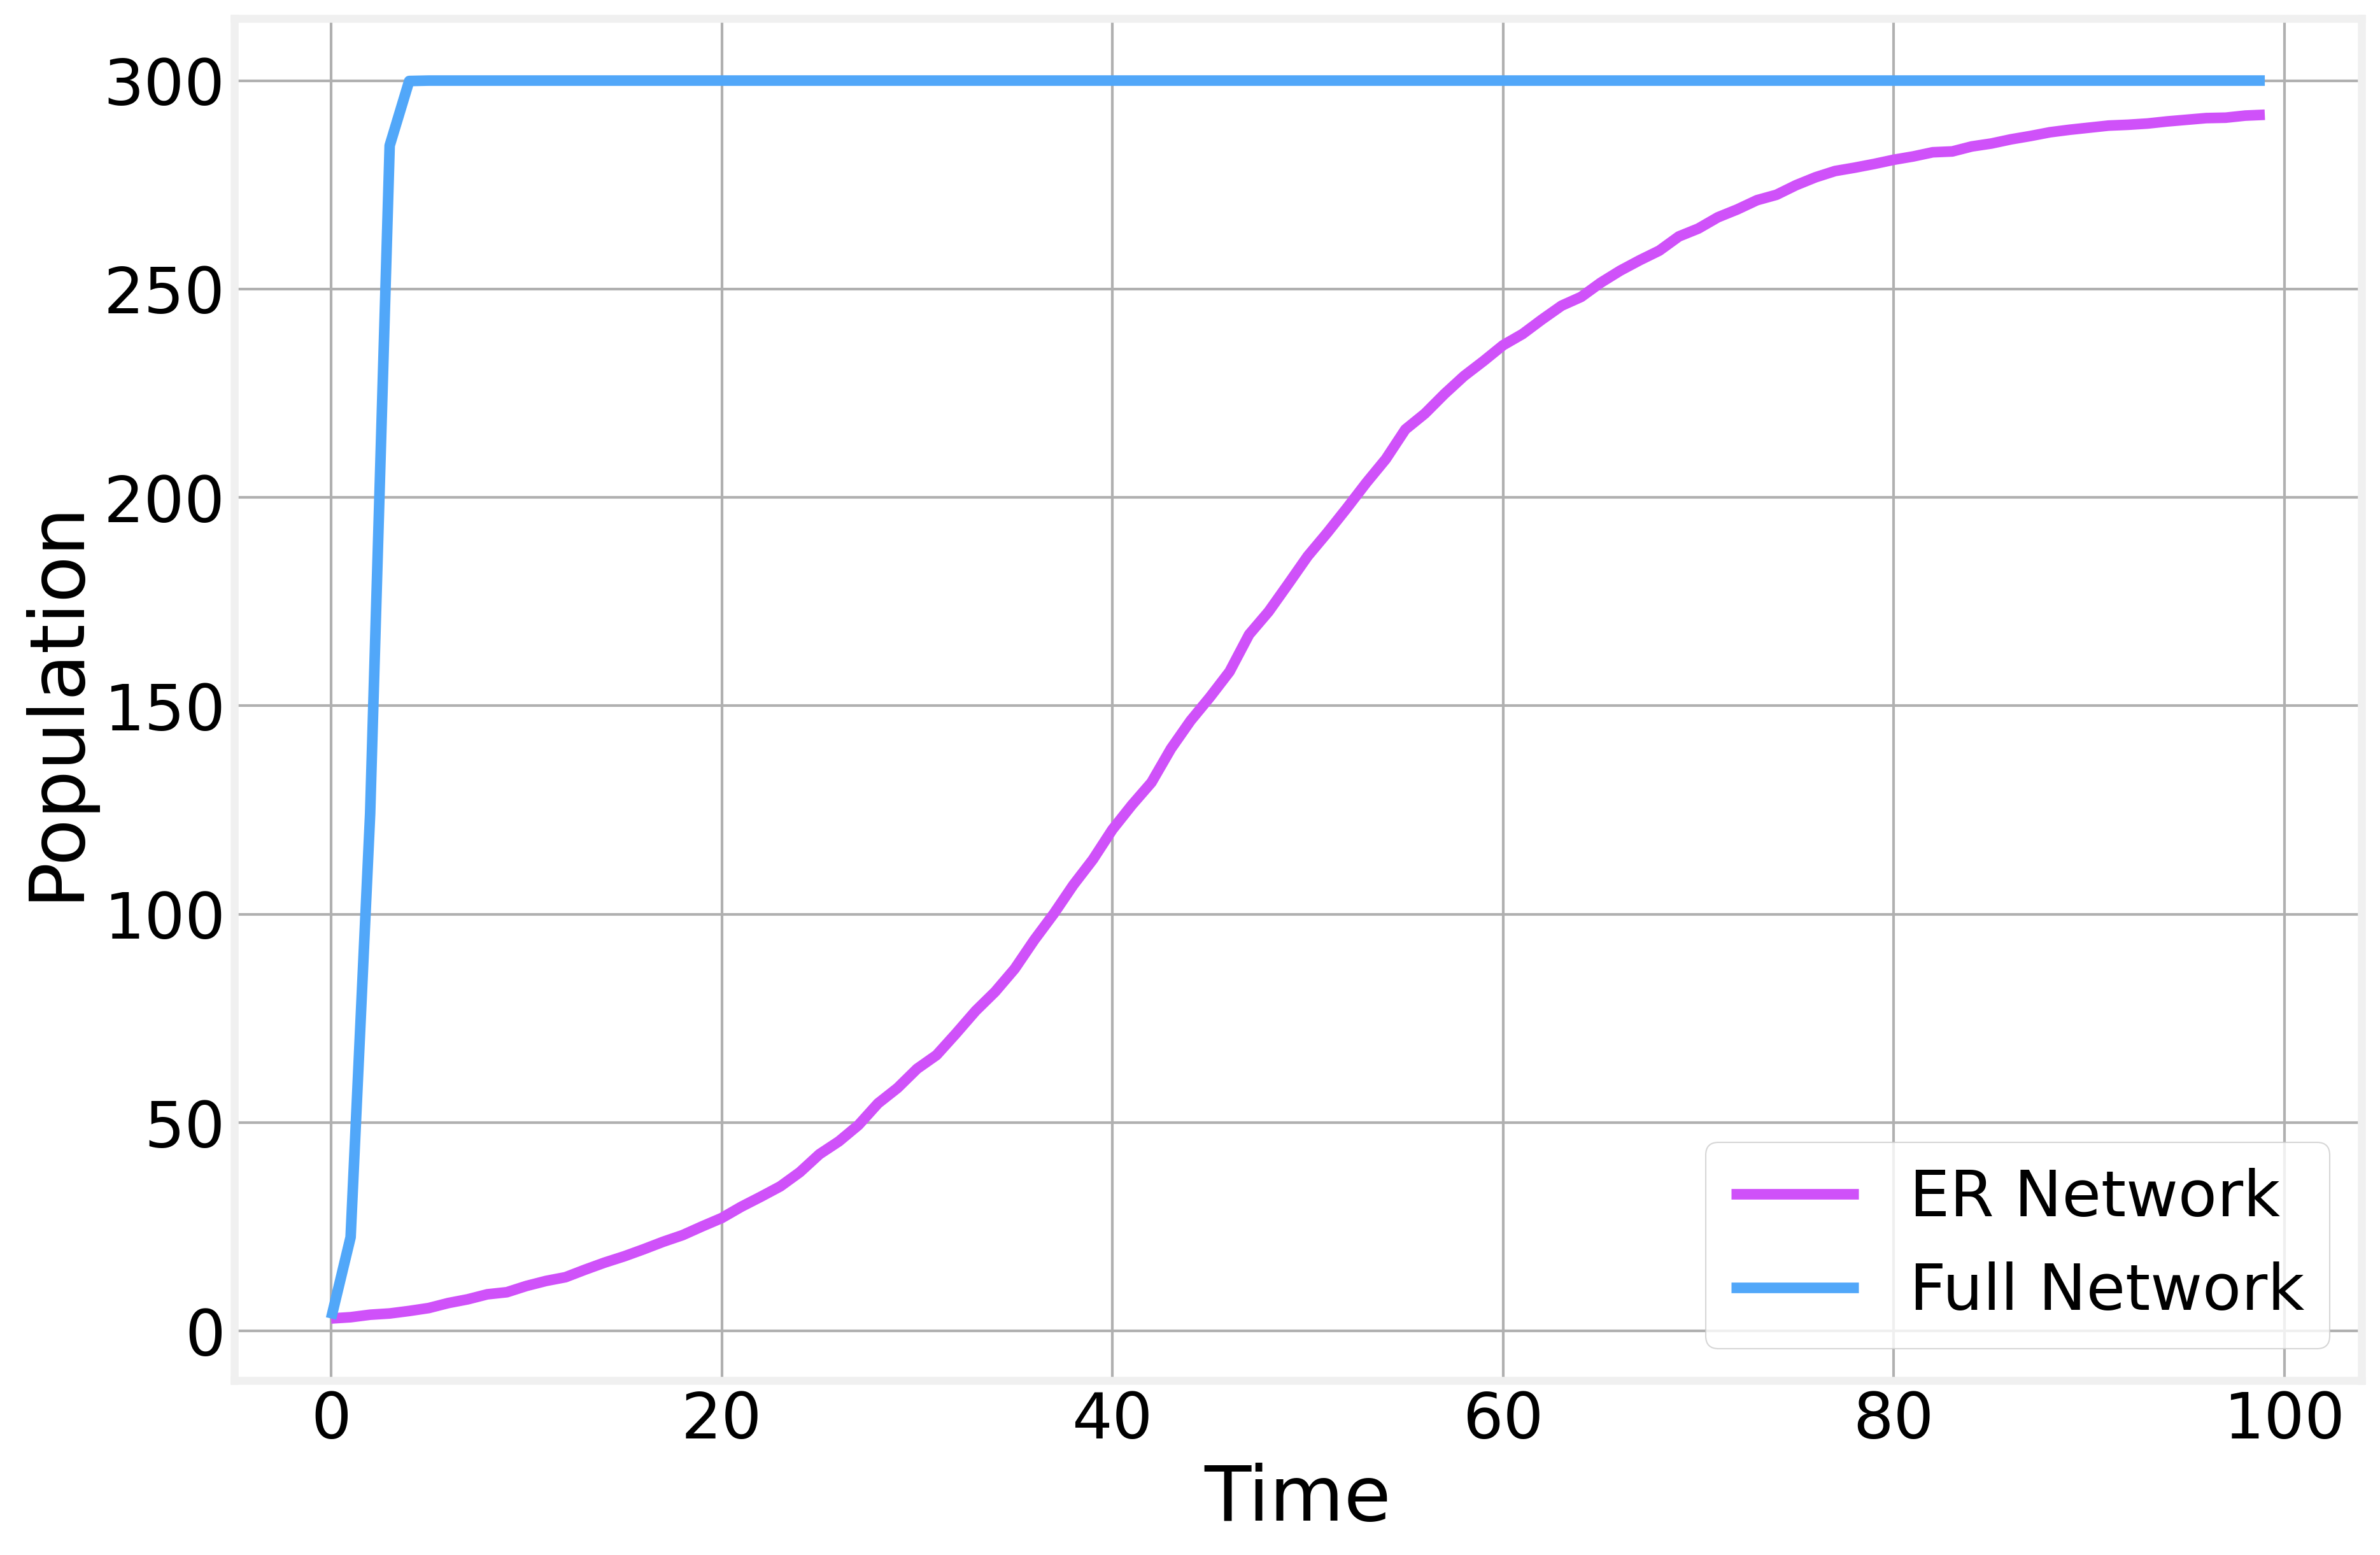

In [15]:
fig, ax = plt.subplots(1)
values_small.mean(axis=1).plot(color=colors[1], ax=ax, label='ER Network')
values_full.mean(axis=1).plot(color=colors[0], ax=ax, label='Full Network')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Population')

But what about two networks with exactly the same average degree, but different topologies? Let's run a Barabasi albert model

In [16]:
BA = nx.barabasi_albert_graph(N, m=3)

In [17]:
SI_BA = NetworkEpiModel(BA)
SI_BA.add_interaction('S', 'I', 'I', 0.02)
SI_BA

Epidemic Model with 2 compartments and 1 transitions:

S + I = I 0.020000

The average degree is exactly the same

In [18]:
SI_BA.kavg_

5.94

In [19]:
values_BA = simulate_runs(SI_BA, Nruns)

100%|██████████| 10/10 [00:01<00:00,  7.45it/s]


Text(0, 0.5, 'Population')

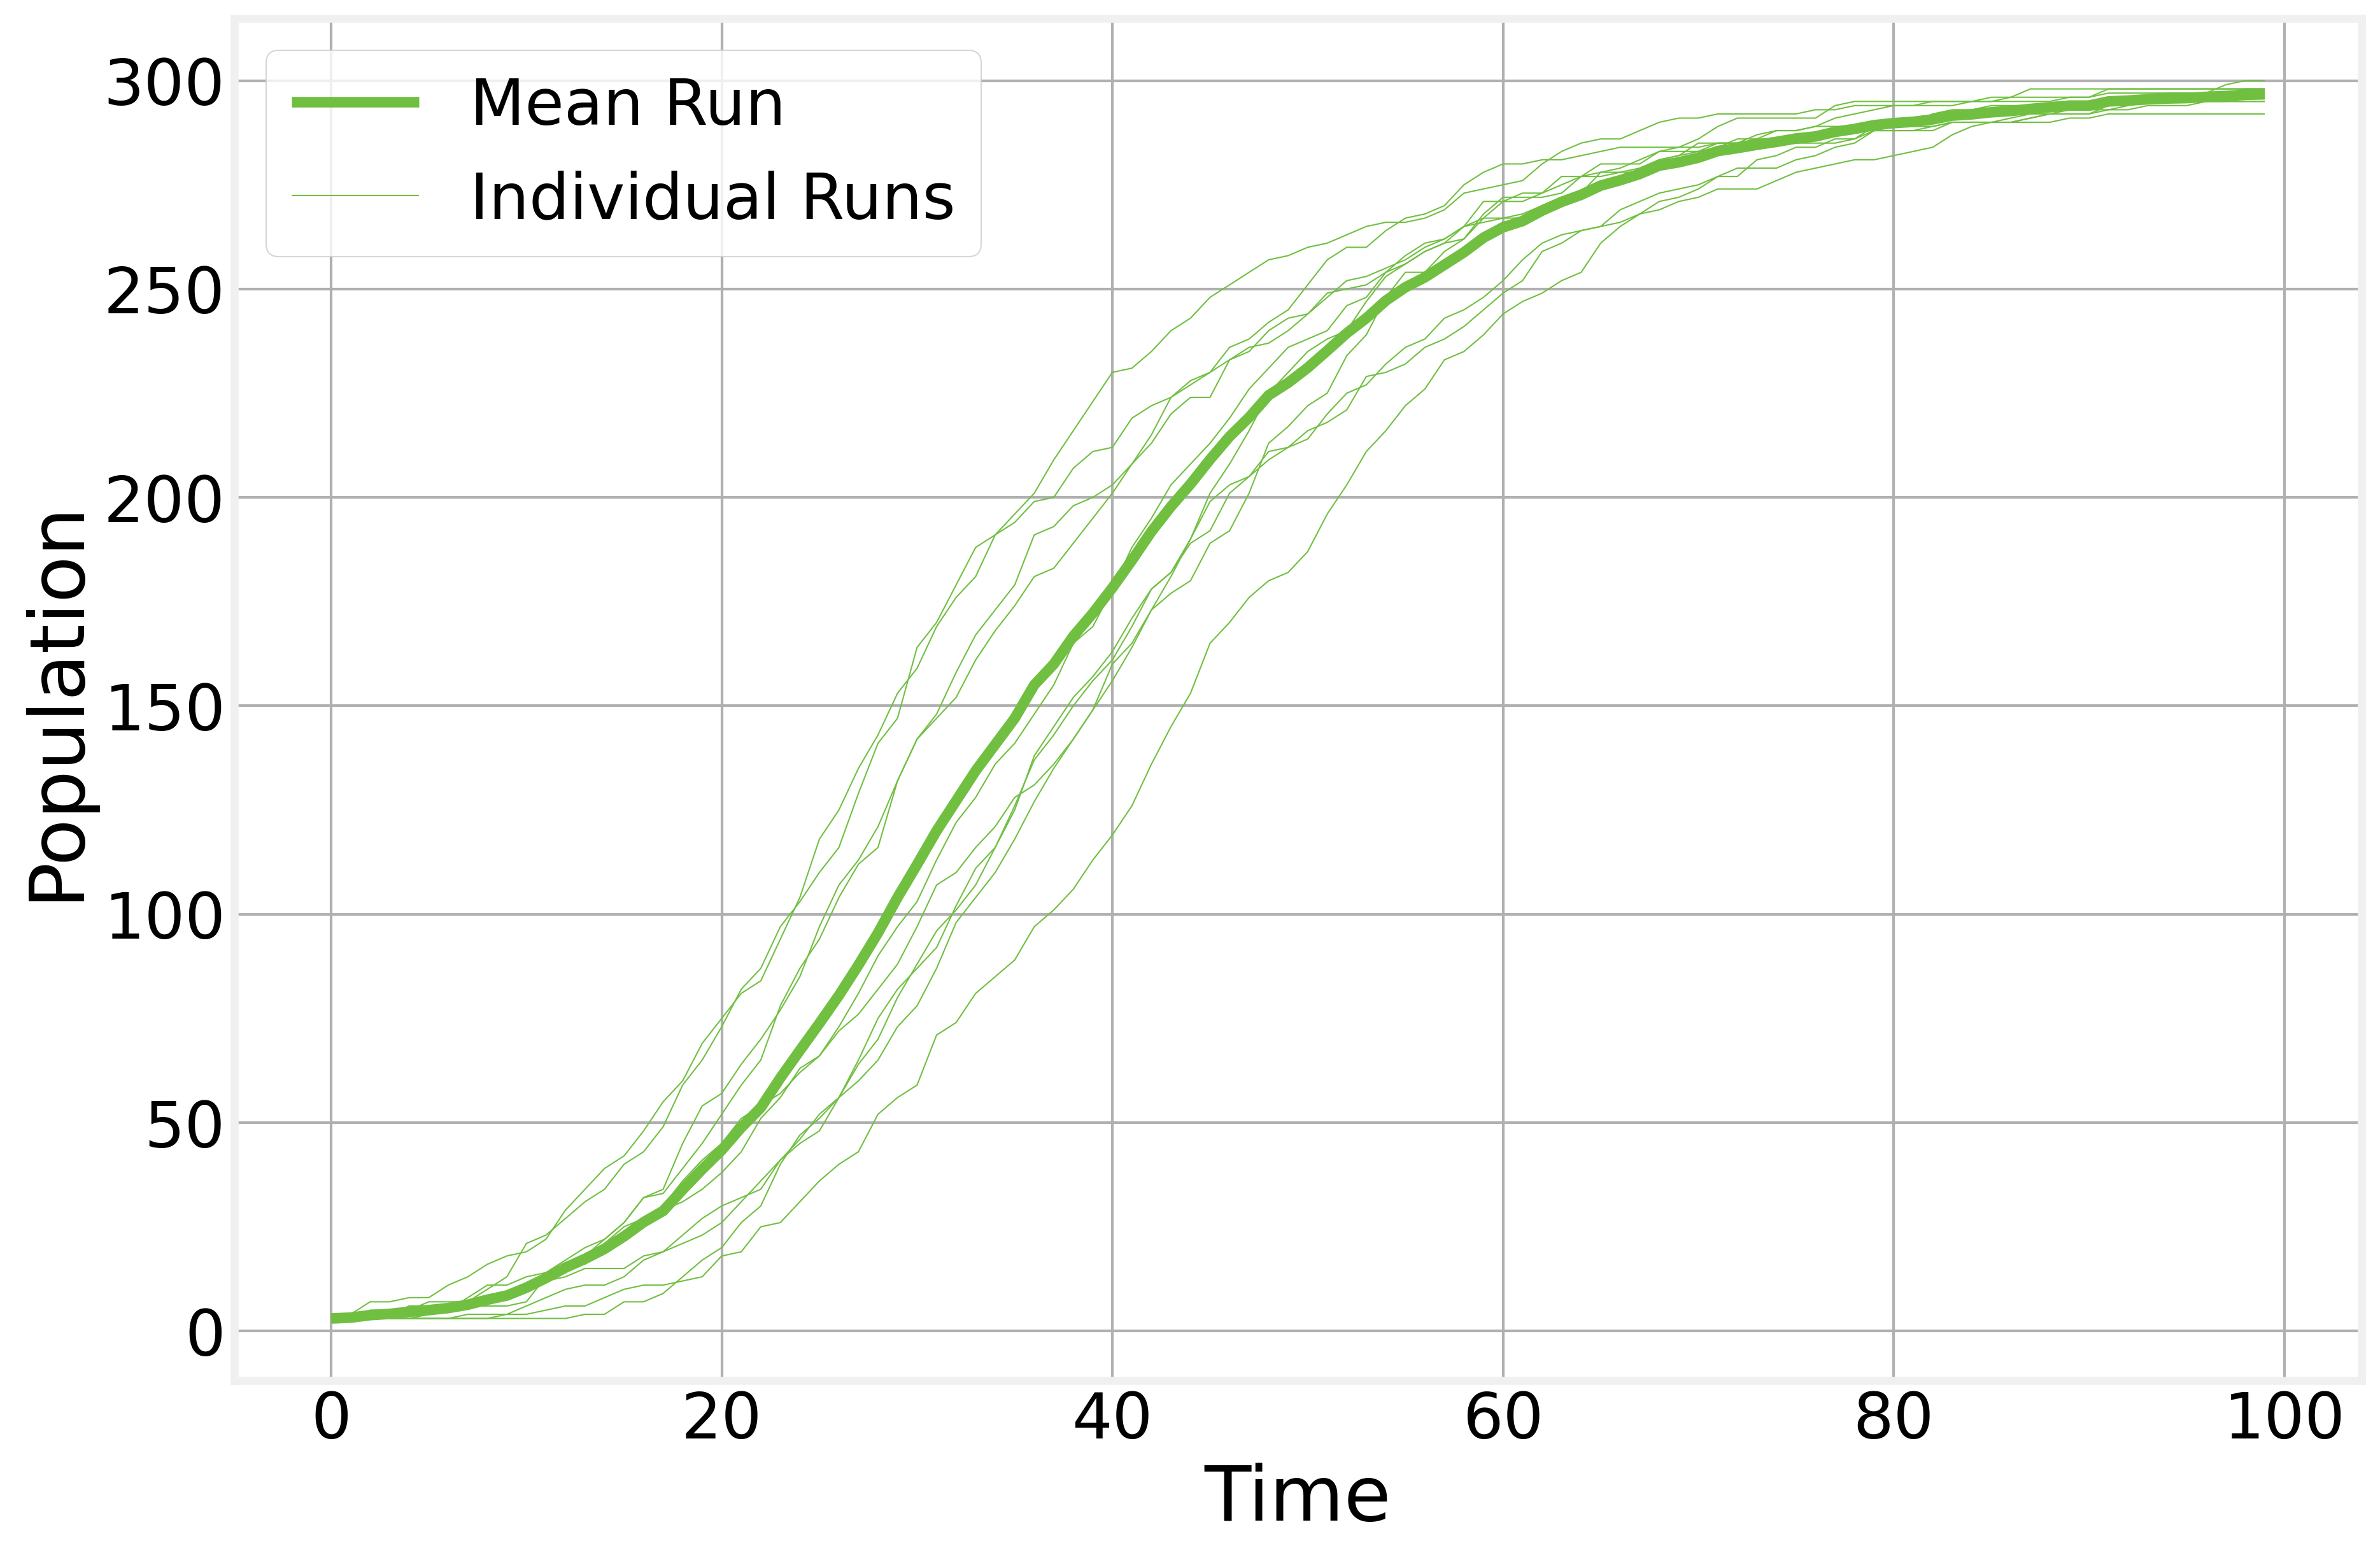

In [20]:
fig, ax = plt.subplots(1)

values_BA.mean(axis=1).plot(color=colors[2], ax=ax)
values_BA.plot(ax=ax, color=colors[2], lw=.5)

ax.get_legend().remove()
ax.legend(['Mean Run', 'Individual Runs'])

ax.set_xlabel('Time')
ax.set_ylabel('Population')

## Topology comparison

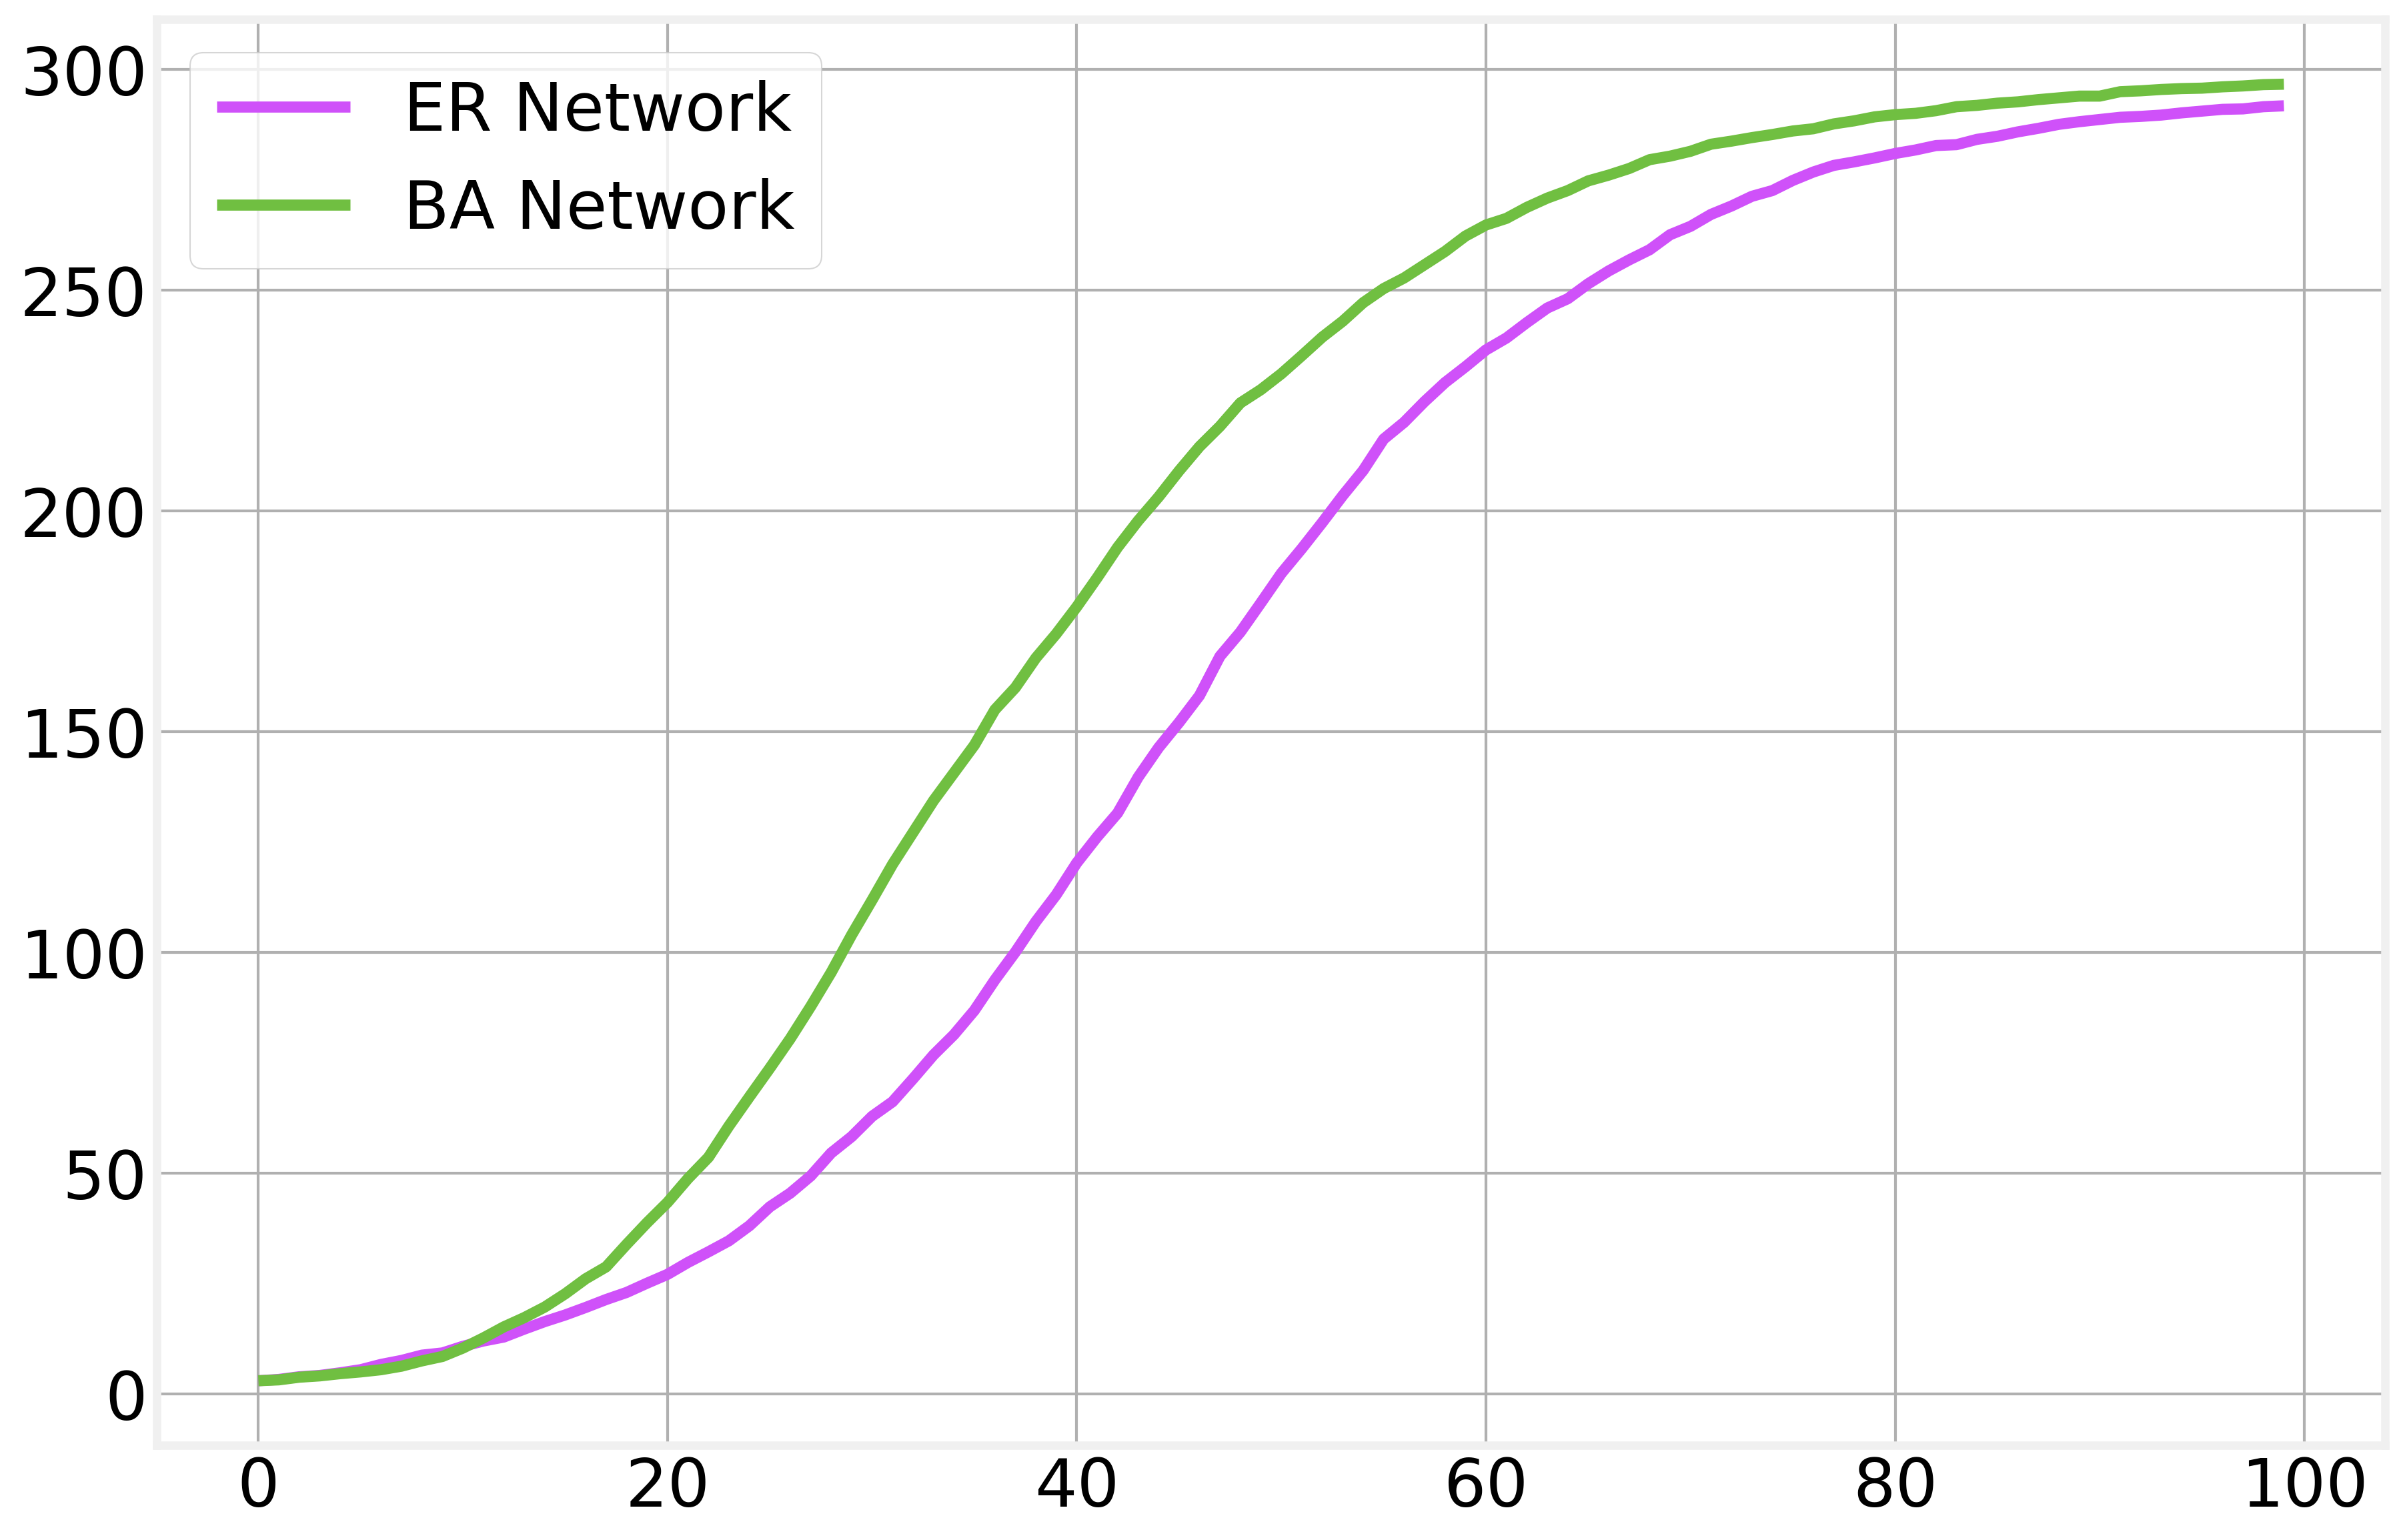

In [21]:
fig, ax = plt.subplots(1)
values_small.mean(axis=1).plot(color=colors[1], ax=ax, label='ER Network')
values_BA.mean(axis=1).plot(color=colors[2], ax=ax, label='BA Network')
ax.legend()

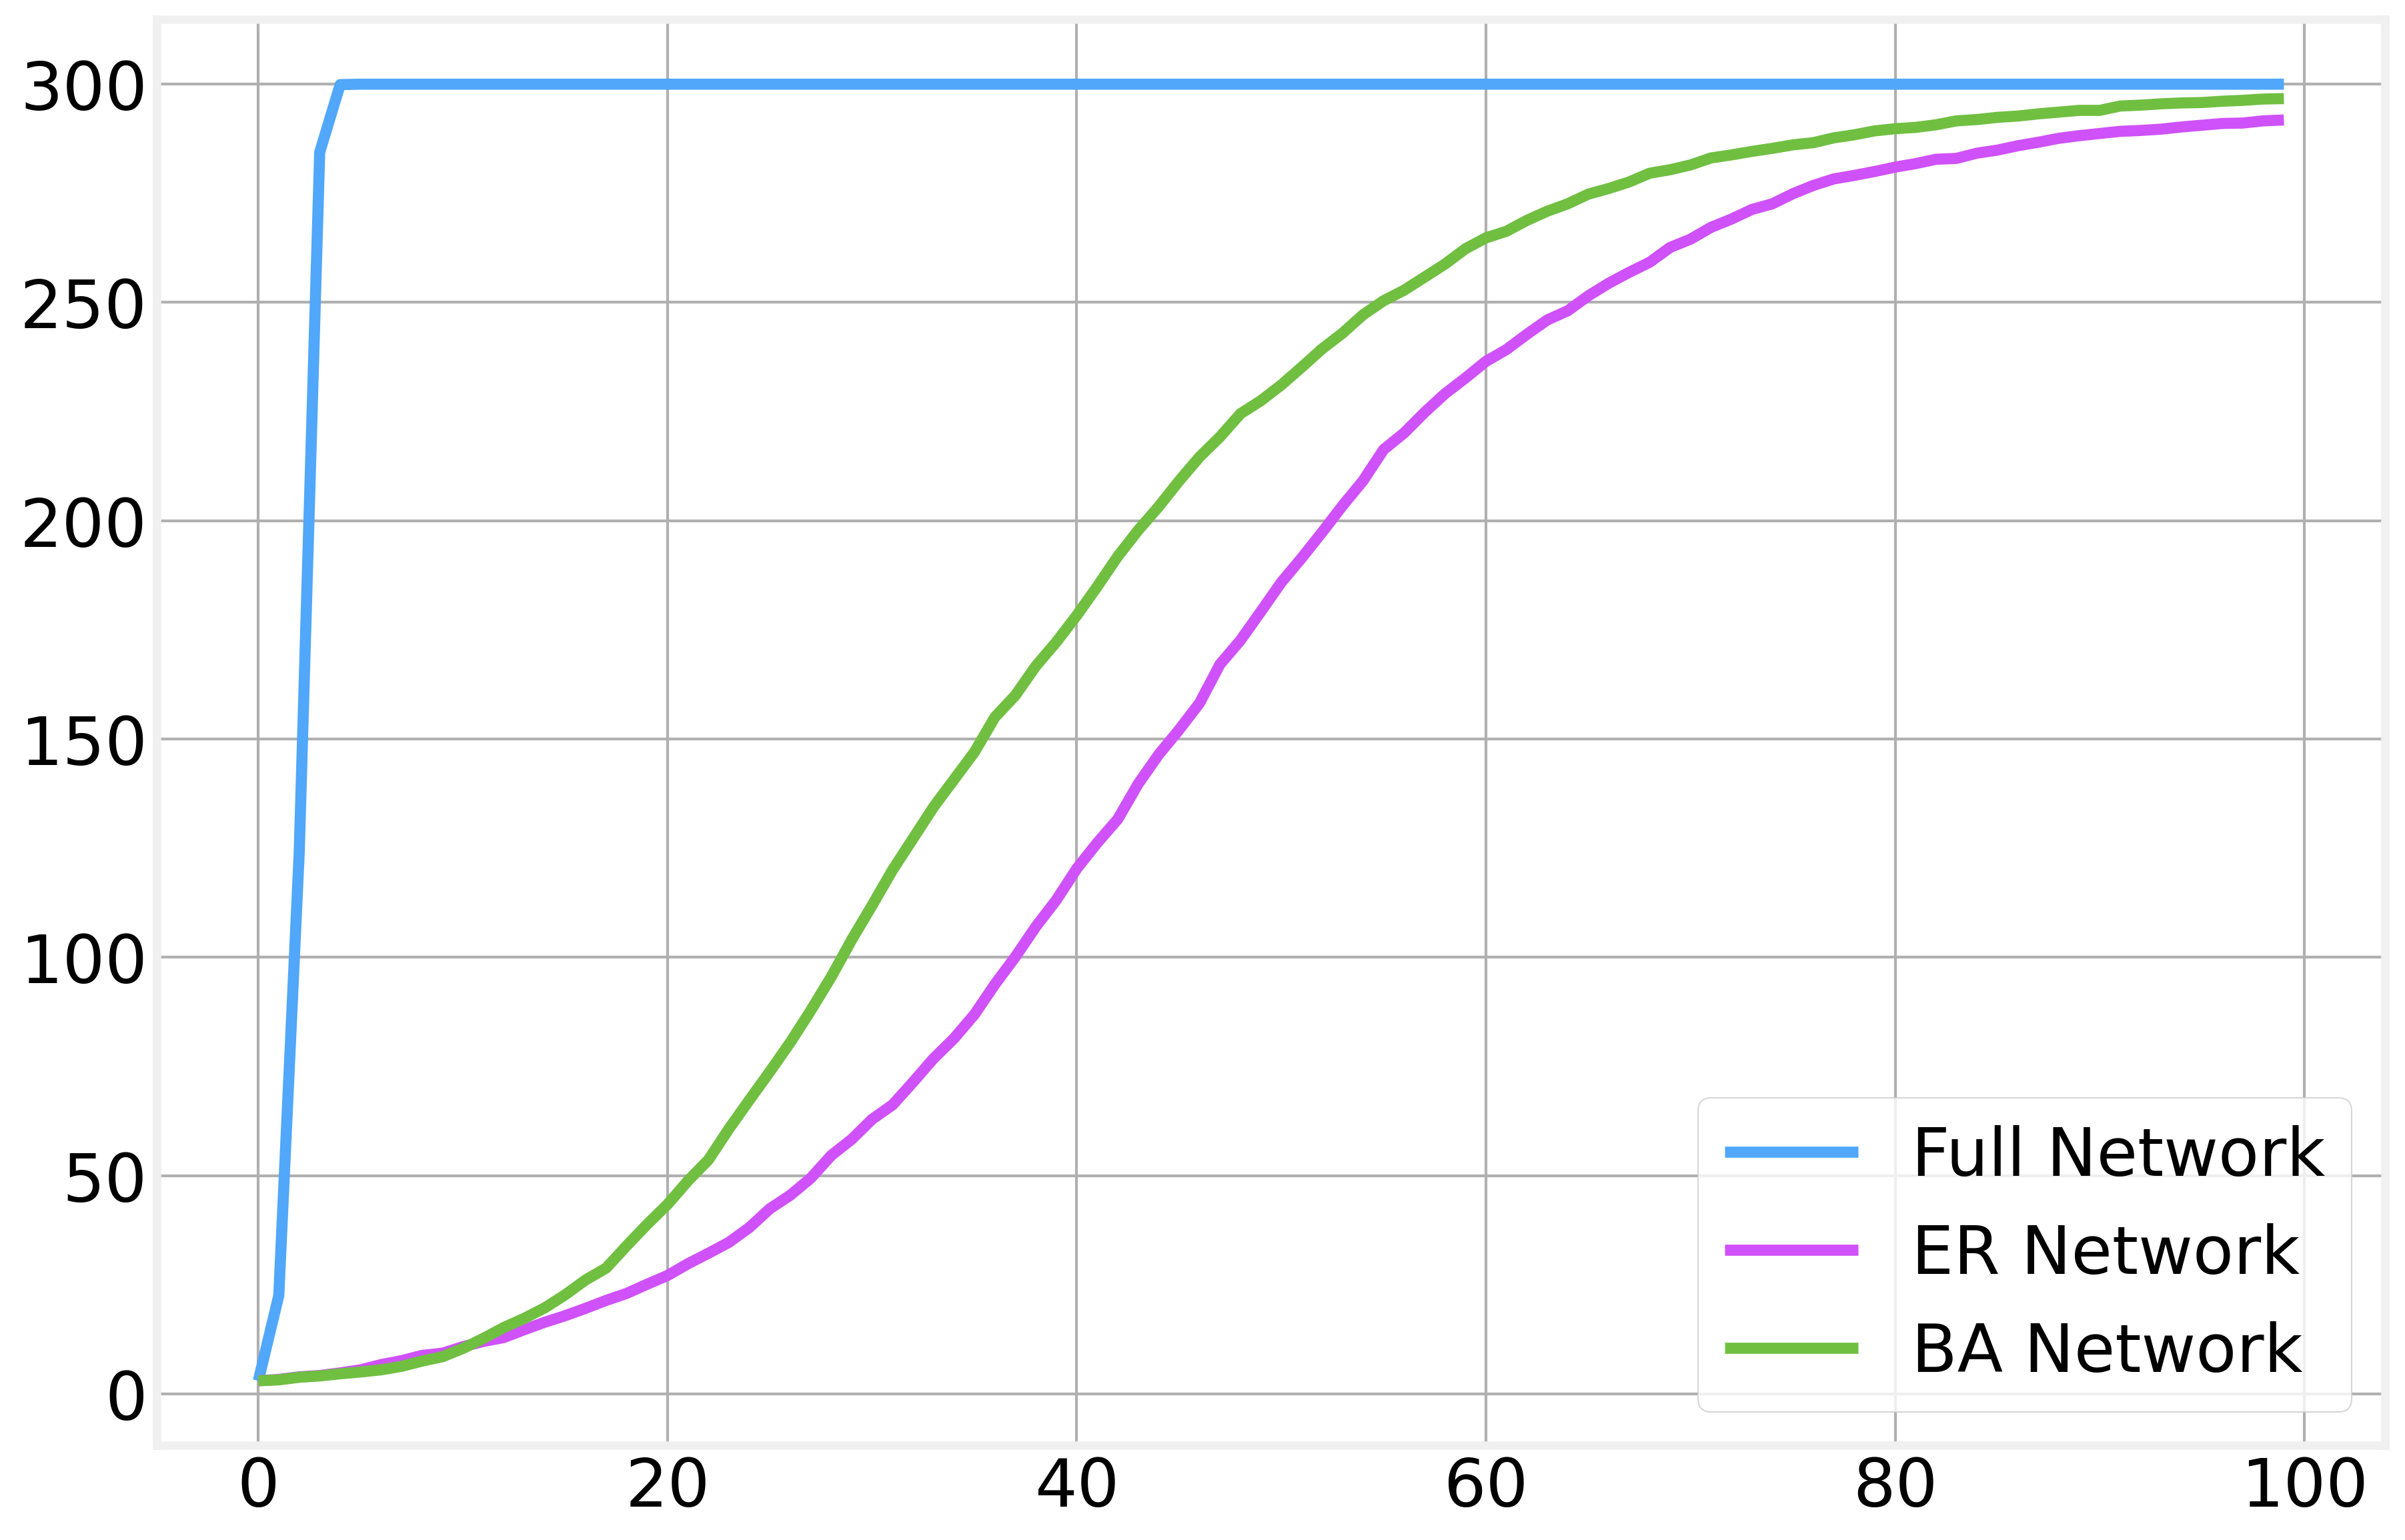

In [22]:
fig, ax = plt.subplots(1)
values_full.mean(axis=1).plot(color=colors[0], ax=ax, label='Full Network')
values_small.mean(axis=1).plot(color=colors[1], ax=ax, label='ER Network')
values_BA.mean(axis=1).plot(color=colors[2], ax=ax, label='BA Network')
ax.legend()

<div style="width: 100%; overflow: hidden; float: center;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>